# Examples for running FLORIS

In [1]:
# load modules
from floris.floris import Floris
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Setup floris and process input file

In [2]:
floris = Floris("example_input.json")

## Calculate Wake

In [3]:
import time

t1 = time.time()

floris.farm.flow_field.calculate_wake()

t2 = time.time()

print('Time to compute wake = ', t2-t1, 's')

Time to compute wake =  0.010185956954956055 s


## Compute Velocities at each Turbine

In [4]:
for coord, turbine in floris.farm.turbine_map.items():
    print(str(coord) + ":")
    print("\tCp -", turbine.Cp)
    print("\tCt -", turbine.Ct)
    print("\tpower -", turbine.power)
    print("\tai -", turbine.aI)
    print("\taverage velocity -", turbine.get_average_velocity())

(0.0, 0.0):
	Cp - 0.46328782548262326
	Ct - 0.7661304442831962
	power - 1712005.1679717556
	ai - 0.2581996920407235
	average velocity - 7.85065163365446
(800.0, 0.0):
	Cp - 0.4591295490754733
	Ct - 0.8126343857218721
	power - 946340.4076651493
	ai - 0.2835712505937994
	average velocity - 6.462368096236684
(0.0, 630.0):
	Cp - 0.46328782548262326
	Ct - 0.7661304442831962
	power - 1712005.1679717556
	ai - 0.2581996920407235
	average velocity - 7.85065163365446
(800.0, 630.0):
	Cp - 0.4591295490754733
	Ct - 0.8126343857218721
	power - 946340.4076651493
	ai - 0.2835712505937994
	average velocity - 6.462368096236684


## Visualization Manager for FLORIS 

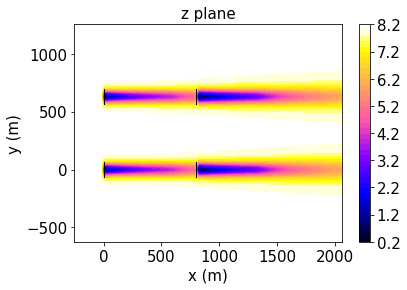

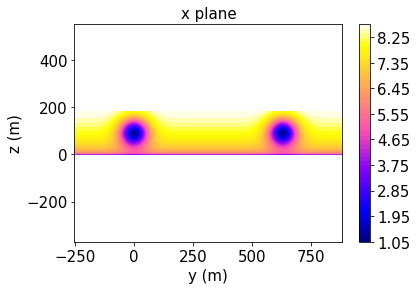

In [5]:
# Visualization
from copy import deepcopy
from visualization_manager import VisualizationManager

ff_viz = deepcopy(floris.farm.flow_field)
grid_resolution = (100, 100, 50)
visualization_manager = VisualizationManager(ff_viz, grid_resolution)
visualization_manager.plot_z_planes([0.5])
visualization_manager.plot_x_planes([0.5])

## Optimize Wind Farm using Wake Steering 

In [6]:
import OptModules  # modules used for optimizing FLORIS
import numpy as np
import imp

imp.reload(OptModules)

# run FLORIS with no yaw
turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
for k,turbine in enumerate(turbines):
    turbine.yaw_angle = 0.0
floris.farm.flow_field.calculate_wake()
power_initial = np.sum([turbine.power for turbine in turbines])  # determine initial power production

# number of turbines
nTurbs = len(turbines)

# set bounds for the optimization on the yaw angles (deg)
minimum_yaw_angle = 0.0
maximum_yaw_angle = 25.0

# compute the optimal yaw angles
opt_yaw_angles = OptModules.wake_steering(floris,minimum_yaw_angle,maximum_yaw_angle)

print('Optimal yaw angles for:')
for i,yaw in enumerate(opt_yaw_angles):
    print('Turbine ', i, ' yaw angle = ', np.degrees(yaw))

Optimizing wake redirection control...
Number of parameters to optimize =  4
Optimal yaw angles for:
Turbine  0  yaw angle =  24.999999987589906
Turbine  1  yaw angle =  8.152804870526513e-09
Turbine  2  yaw angle =  24.999999987553267
Turbine  3  yaw angle =  8.133263542563601e-09


## Calculate Power Gain

In [7]:
# assign yaw angles to turbines
turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
for i,turbine in enumerate(turbines):
    turbine.yaw_angle = opt_yaw_angles[i]
    
# compute the new wake with yaw angles
floris.farm.flow_field.calculate_wake()

# optimal power 
power_opt = np.sum([turbine.power for turbine in turbines]) 

print('Power increased by ', 100*(power_opt-power_initial)/power_initial, '%')


Power increased by  6.222567052402905 %


## Compute Annual Energy Production

In [8]:
from scipy.optimize import minimize

t1 = time.time()

# wind speed and wind directions
wind_direction = np.linspace(0,350,36)
wind_speed = np.linspace(0,29,30)

# assume uniform distribution of wind speeds and wind directions 
# NOTE: user should specify specific distributions for their farms
freq = np.ones(len(wind_direction)*len(wind_speed))
freq = freq/np.sum(freq)

# initialize variables
power0    = np.zeros(len(wind_direction)*len(wind_speed))
powerOpt  = np.zeros(len(wind_direction)*len(wind_speed))
yawAngles = np.zeros((len(wind_direction)*len(wind_speed),nTurbs))
windSpeed = np.zeros(len(wind_direction)*len(wind_speed))
windDir   = np.zeros(len(wind_direction)*len(wind_speed))

count = 0

print('Optimizing AEP...')

for i,wd in enumerate(wind_direction):
    for j,ws in enumerate(wind_speed):
        
        #print('Wind speed = ', ws, ' Wind direction = ', wd)
        
        # set initial wind direction and wind speed for FLORIS
        floris.farm.flow_field.wind_direction = np.radians(wd - 270) # frame of reference is west
        floris.farm.flow_field.wind_speed = ws
        floris.farm.flow_field.initial_flowfield = floris.farm.flow_field._initial_flowfield()
        floris.farm.flow_field.u_field = floris.farm.flow_field._initial_flowfield()
        
        # run FLORIS with no yaw
        turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
        for k,turbine in enumerate(turbines):
            turbine.yaw_angle = 0.0
            
        floris.farm.flow_field.calculate_wake()
        turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
        power0[count] = freq[count]*np.nan_to_num(np.sum([turbine.power for turbine in turbines]) )
        
        # optimize FLORIS for yaw
        # set initial conditions
        x0          = [np.radians(1.0) for turbine in turbines]
        bnds        = [(np.radians(minimum_yaw_angle), np.radians(maximum_yaw_angle)) for turbine in turbines]
        
        # optimize plant
        residual_plant = minimize(OptModules.optimize_plant,x0,args=(floris),method='L-BFGS-B', bounds=bnds)
        turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
        for k,turbine in enumerate(turbines):
            turbine.yaw_angle = residual_plant.x[k]
            yawAngles[count,k] = residual_plant.x[k]
            
        floris.farm.flow_field.calculate_wake()
        turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
        powerOpt[count] = freq[count]*np.nan_to_num(np.sum([turbine.power for turbine in turbines]))
        
        #print('Power gain = ', 100*(powerOpt[count]-power0[count])/power0[count], power0[count],powerOpt[count])
        
        count = count + 1
        
print('AEP gain = ', 100*(np.sum(powerOpt)-np.sum(power0))/np.sum(power0))
t2 = time.time()

print('Total time for AEP optimization = ', t2-t1, 's')
        

Optimizing AEP...
AEP gain =  0.301029889353
Total time for AEP optimization =  155.82100009918213 s
